# Genetic algorithms using `numpy`

In this demonstration, we will code up step-by-step, a simple GA for optimizing a trivial function with constraints. Further exploration in this example would be very useful for your project.

In [1]:
import numpy as np

# Do some Ipython black magic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
SEED = 42
rng = np.random.default_rng(seed=SEED)

## Problem statement

We need to maximize the function  $ f(\mathbf{x}) = \sum_{i=1}^{6} w_i x_i $ for a given set of weights $ w_i $, with the constraints that $ x_i \; \in \; [-4,4] \; \forall \; i$. This means that the domain $\mathbb{D}$ of the search is $ \mathbb{D}:= [-4,4]^6$. The optimization problem can be succinctly represented as $\left(\mathbb{D}, \mathbb{R} , \mathbf{f}, \geq \right)$.

## Ease of solving the problem

We note that this example is trivial because given a set of weights, we need to pick either $x_i=-4$ or $x_i=4$ as the objective function is linear. That's precisely the point however, as we know the solution to the problem, and we can compare how GA performs (as a search algorithm in itself, and against design parameters)

## Given
The weight vector $\mathbf{w} = [6,8,-6,3,3,-4]$. For this case then, the optimal solution is $\mathbf{x}^* = [4, 4, -4, 4, 4, -4]$ which gives a maximum possible objective value $f^* = 120$

In [3]:
N_WEIGHTS = 6 # Helper variable
WEIGHTS = np.array([6,8,-6,3,3,-4], dtype = np.float64) # Optional dtype argument

In [4]:
# Confirm the shape so that we are happy
np.shape(WEIGHTS)

(6,)

#  Representation

How do you want to encode this problem?  We need to keep in mind that variation needs to be done on this representation.

In [5]:
# I can define my optimal solution vector now, since I have decided my representation
X_STAR = np.array([4, 4, -4, 4, 4, -4], dtype = np.float64)
F_STAR = 120

Now that we have picked representation, let's start off the problem. We need to pick a population size (i.e. number of parents in the initial generation). Let's pick a nice number, say 10  

In [6]:
# Size of the population
POP_SIZE = 10

Remember! Each member of this population is a vector with shape `(6,)`. Is there a way to efficiently represent/generate/work with this entire population all at one go?

Of course! Put them together as a 2 dimensional array!

In [7]:
# Helper variable that generates POP_SIZE x NUM_WEIGHTS population
DOFS_IN_POP = (POP_SIZE, N_WEIGHTS)

The population will have `POP_SIZE` chromosomes where each chromosome has `NUM_WEIGHTS` genes. Let's generate the initial population that our GA algorithm will work on. This population needs to be randomly initialized, say around $0.0$. (Hint : The `numpy.random` module comes to mind)

In [8]:
curr_population = rng.uniform(-4, 4, size=DOFS_IN_POP)

In [9]:
curr_population.shape

(10, 6)

# Fitness assignment
In this demo, we assign fitness directly using the objective function (without penalty, we'll deal with constraints later on). However you can best decide what fitness works for your problem (competitive? informal?...)

In [10]:
def calc_fitness(t_pop):
    """ Calculates fitness given the population using global weights
    The fitness function calulates the sum of products between each
    input and its corresponding weight.
    
    Returns a (POP_SIZE, ) numpy array
    """       
    
    # fitness = t_pop.dot(WEIGHTS) 
    fitness = t_pop @ WEIGHTS
    # fitness = np.dot(t_pop, WEIGHTS)
    
    # fitness = 0.0
    # for i range(t_pop.shape[0]):
    #     fitness += np.sum(t_pop[i], WEIGHTS)
    
    return fitness

In [11]:
def test_io_shape():
    for s in [32, 64]:
        t_pop_test = np.empty((s, N_WEIGHTS))
        assert calc_fitness(t_pop_test).shape == (s,)
test_io_shape()

In [12]:
# Sanity check
my_fitness = calc_fitness(curr_population)
print(my_fitness.shape)
print(my_fitness)

(10,)
[-28.19741589  30.74530231  38.99999949   6.99010621 -29.68665133
  56.12687809 -14.28882157  -6.95695417 -10.10399845  35.12659324]


# Selection for variation

### How do you select parents to spread their genes? 
One way to do it is to select *best* parents only to mate. This is an example of a **determinstic selection scheme**, wherein we rank them by fitness and consider the best ones.

### How many parents to select for mating? 
This is up to the user. Some people prefer to use heuristics based on the population size for determining the mating pool size. Sometimes it depends on the selection scheme used (for example, in tournament selection where the $T$ parameter, along with the population size determines the mating pool size).

For simplicity in this demo, let's fix the number of parents that are selected to mate at every iteration and store it as a variable.


In [13]:
N_MATING = 5 # Fill in a number of your choice > 0 

def select_determinstic(t_pop, t_fitness):
    """ Given current population t_pop, select N_MATING number
    of parents using determinstic selection scheme
    based on t_fitness (the fitness of the population) 

    Returns parents and their fitness as a tuple (parent, fitness_of_parents)
    """
    # Fill in details here 
    # parents = np.empty((N_MATING, N_WEIGHTS))
    
    sorted_indices = np.argsort(t_fitness)
    top_indices = sorted_indices[::-1][:N_MATING]
    parents = t_pop[top_indices]
    
    return (parents, calc_fitness(parents))

In [14]:
def test_selection_shape():
    test_N = 10
    test_t_pop = np.empty((test_N, N_WEIGHTS), dtype=float)
    test_fitness = calc_fitness(test_t_pop)
    
    parents, fitness = select_determinstic(test_t_pop, test_fitness)
    assert parents.shape == (N_MATING, N_WEIGHTS)
    assert fitness.size == N_MATING
    assert fitness.max() in test_fitness
test_selection_shape()

In [15]:
# Sanity check
my_parents, my_par_fitness = select_determinstic(curr_population, my_fitness)
my_parents
my_par_fitness

array([[ 1.95809725,  3.74007786, -1.39339713, -1.03632235, -0.24355351,
        -2.48422913],
       [ 1.15092096,  2.58209291, -0.45268641, -2.18209023,  0.4366783 ,
        -3.48946195],
       [ 1.64132303,  2.24583225, -0.3286738 ,  0.54992957, -2.88162401,
        -3.08375941],
       [ 2.08911762,  2.28851444, -2.97509094, -0.3969125 , -1.03361581,
         3.41411991],
       [ 2.62104938,  1.05331519,  2.06470192, -1.16379225,  3.7655842 ,
         3.14496897]])

array([56.12687809, 38.99999949, 35.12659324, 30.74530231,  6.99010621])

### Can you show me an example of stochastic selection?

Let's implement Stochastic Universal Sampling, which consists of

* Sampling rate assignment
* Sampling

I will demonstrate this in class as its a bit more involved.

In [16]:
def select_stochastic(t_pop, t_fitness):
    """ Given current population t_pop, select N_MATING number of parents using SUS
    based on t_fitness 

    Returns parents and their fitness (just because)
    """

    ''' Sampling rate assignment using linear rank-based sampling
    '''
    # Rank based on max fitness
    # Arranged from min-> max fitness
    # Do the same for parents later on
    idx = np.argsort(t_fitness)

    # Copied shamelessly from https://stackoverflow.com/a/5284703
    r_i = np.empty_like(idx)
    r_i[idx] = np.arange(len(t_fitness))
 
    # Same as 
    # r_i = np.argsort(idx)

    """
        >>> t_fitness
        >>> array([-18.29817097,  22.688013  ,  65.55614464, -22.39372802,
           -11.53236791,  40.55497738, -13.77672983,  14.9189356 ,
            60.09509336,  32.67900684])

        >>> idx
        >>> [3 0 6 4 7 1 9 5 8 2]

        >>> r_i
        >>> [1 5 9 0 3 7 2 4 8 6]
    """

    # Calculate linear weighting with alpha = 2
    p_i = r_i + 2

    # Calculate q_i as an avverage measure of p_i
    sum_pi = np.sum(p_i)
    q_i = p_i / sum_pi

    # Rank from biggest to least for ease of use
    q_idx = np.argsort(q_i)

    # Regular q_i is for t_pop
    # The sorted q_i is now for (t_pop)[q_idx]
    # The reversed q_i is then for ((t_pop)[q_idx])[::-1]
    
    q_i = q_i[q_idx]
    q_i = q_i[::-1]


    ''' With this sampling rate q_i pick up four parents
    '''
    # Increment to generated random number
    random_increment = 1./N_MATING

    # Generate a random number
    random_val = np.random.rand(1, )

    # Select four zones of q_i to select
    arrow_locations = random_val + random_increment * np.arange(N_MATING)
    """    
        >>> arrow_locations
        >>> [0.52196859 0.77196859 1.02196859 1.27196859]
    """
    
    # Ensure it stays within 1
    arrow_locations %= 1
    """    
        >>> arrow_locations
        >>> [0.52196859 0.77196859 0.02196859 0.27196859]
    """

    # In place sorting to get (r, r+1/N_MATING, r + 2/N_MATING ...., r + (N_MATING-1)/N_MATING)
    arrow_locations.sort()
    """    
        >>> arrow_locations
        >>> [0.02196859 0.27196859 0.52196859 0.77196859]
    """

    # Based on arrow locations, pick the parents
    cum_qi = np.cumsum(q_i)
    """    
        >>> cum_qi
        >>> [0.16923077 0.32307692 0.46153846 0.58461538 0.69230769 0.78461538
     0.86153846 0.92307692 0.96923077 1.        ]
    """
    
    # Where do you find the arrows within cum_qi
    zone_belong = np.searchsorted(cum_qi, arrow_locations)
    # print(zone_belong)
    """    
        >>> zone_belong
        >>> [0 1 3 5]
    """

    # zone_belong returns index of individuals in the max-->min list 
    # I want indices in the min--> max list
    # One hacky way of doing this is just do a size-1 subtraction
    zone_belong = POP_SIZE - zone_belong - 1
    
    # The q_i of the selected indviduals
    parents = t_pop[q_idx][zone_belong]
    par_fitness = t_fitness[q_idx][zone_belong]

    return (parents, par_fitness)

# Variation
Variation has two operations : crossover/recombination (produce new offspring from the parents selected in the prior step) and mutation (produced mutated/randomly offset offspring). Let's see each one separately.

### Recombination
For this demonstration, lets do a one-point crossover. This means we naively *mix* the solution vectors---we take some  components from one parent and the rest from another parent... 

Before proceeding, we want to determine the limit of offspring vectors to be produced. This has to be a reasonable number and should depend on the population and the number of parents selected for mating. This also corresponds to the $\lambda$ deterministic selection schemes.

We also need to select $p_c$, the crossover rate---it determines the probability of a crossover happening between two parents.

In our demo, let's fix $p_c$ to 1 (recombination happens always). We also fixed the offspring size above to $0.5 \cdot {\text{N-MATING}\choose 2} = 3$. This allows every selected parent to propogate their genes. The parent vectors are chosen in a fixed fashion (1 mates with 2, 2 with 3 and so on...)

Where to crossover? Sometimes we use an additional random integer (respecting array range constraints) that determines at which location a crossover should occur. In our example below, let's perform a *uniform* one-point crossover (uniform in the sense that we always do crossover at a selected index)

In [17]:
from math import comb

In [18]:
N_OFFSPRING: int = comb(N_MATING, 2) // 2
IDX_CROSSOVER: int = N_WEIGHTS // 2

In [19]:
def crossover(t_parents):
    """ Given a set of parents, combine them and return offspring vectors
    
    t_parents: (N_MATING, N_WEIGHTS)
    
    Returns the offsprings and their fitness
    """
    
    # Create an emppty vector
    offspring = np.empty((N_OFFSPRING, N_WEIGHTS))

    # Fill in crossover details
    for i in range(N_OFFSPRING):
        parent_indices = rng.choice(np.arange(N_MATING), size=2, replace=True)
        parent1 = t_parents[parent_indices[0], :IDX_CROSSOVER]
        parent2 = t_parents[parent_indices[1], IDX_CROSSOVER:]
        
        offspring[i] = np.concatenate([parent1, parent2])
    
    return (offspring, calc_fitness(offspring))

In [20]:
def test_crossover_shape_basic():
    N_OFFSPRING, N_WEIGHTS, N_MATING, IDX_CROSSOVER = 4, 6, 2, 3
    parents = np.arange(N_MATING * N_WEIGHTS).reshape(N_MATING, N_WEIGHTS)
    offspring, fitness = crossover(parents)

    # Assertions
    assert offspring.shape == (N_OFFSPRING, N_WEIGHTS), f"Offspring shape mismatch: {offspring.shape}"
    assert fitness.shape[0] == N_OFFSPRING, f"Fitness length mismatch: {fitness.shape[0]}"

Does crossover create new offspring?

In [21]:
# Sanity check
my_offspring,  my_offspring_fitness = crossover(my_parents)
my_parents
my_offspring

array([[ 1.95809725,  3.74007786, -1.39339713, -1.03632235, -0.24355351,
        -2.48422913],
       [ 1.15092096,  2.58209291, -0.45268641, -2.18209023,  0.4366783 ,
        -3.48946195],
       [ 1.64132303,  2.24583225, -0.3286738 ,  0.54992957, -2.88162401,
        -3.08375941],
       [ 2.08911762,  2.28851444, -2.97509094, -0.3969125 , -1.03361581,
         3.41411991],
       [ 2.62104938,  1.05331519,  2.06470192, -1.16379225,  3.7655842 ,
         3.14496897]])

array([[ 1.64132303,  2.24583225, -0.3286738 , -0.3969125 , -1.03361581,
         3.41411991],
       [ 2.08911762,  2.28851444, -2.97509094,  0.54992957, -2.88162401,
        -3.08375941],
       [ 2.62104938,  1.05331519,  2.06470192,  0.54992957, -2.88162401,
        -3.08375941],
       [ 1.95809725,  3.74007786, -1.39339713, -0.3969125 , -1.03361581,
         3.41411991],
       [ 1.64132303,  2.24583225, -0.3286738 , -0.3969125 , -1.03361581,
         3.41411991]])

It does! Are the offsprings fitter than their parents?

In [22]:
# Check if recombination is useful
my_par_fitness
my_offspring_fitness

array([56.12687809, 38.99999949, 35.12659324, 30.74530231,  6.99010621])

array([11.83857438, 54.03332117, 17.10456058, 32.08152462, 11.83857438])

They are! This is good news...

### Mutation
For this demonstration, lets add uniform random numbers drawn between $[-0.5, 0.5)$ to the offspring. But let's not do it everytime---we will do that with a probability $p_m = 0.5$, sampled for each offspring. Recollect that this is the mutation rate parameter.

In [23]:
PM = 0.5 # Mutation rate parameter
def mutation(t_offspring):
    """ Given a set of offsprings, introduce mutation in them
   
    Returns the mutated offsprings and their fitness
    """
    # Fill in details
    mutated_offspring = t_offspring.copy()
    
    mask = rng.uniform(size=t_offspring.shape) < PM
    drawn_numbers = rng.uniform(-0.5, 0.5, size=t_offspring.shape)
    
    # mutated_offspring += drawn_numbers * mask
    mutated_offspring[mask] += drawn_numbers[mask]
    
    return (mutated_offspring, calc_fitness(mutated_offspring))

Can we see some mutation?

In [24]:
# Sanity checks
my_mut_offspring, my_mut_offspring_fitness = mutation(my_offspring)
my_offspring
my_mut_offspring

array([[ 1.64132303,  2.24583225, -0.3286738 , -0.3969125 , -1.03361581,
         3.41411991],
       [ 2.08911762,  2.28851444, -2.97509094,  0.54992957, -2.88162401,
        -3.08375941],
       [ 2.62104938,  1.05331519,  2.06470192,  0.54992957, -2.88162401,
        -3.08375941],
       [ 1.95809725,  3.74007786, -1.39339713, -0.3969125 , -1.03361581,
         3.41411991],
       [ 1.64132303,  2.24583225, -0.3286738 , -0.3969125 , -1.03361581,
         3.41411991]])

array([[ 1.64132303,  2.24583225, -0.74102388, -0.77890659, -0.57171814,
         3.8227006 ],
       [ 2.28882475,  2.28851444, -2.50591456,  0.82868047, -2.66473383,
        -3.13439791],
       [ 2.62104938,  1.05331519,  2.06470192,  0.54992957, -3.17926065,
        -3.08375941],
       [ 2.03731682,  3.41685064, -1.03678285, -0.3969125 , -0.81415285,
         3.34621295],
       [ 1.64132303,  2.32993022, -0.3286738 , -0.81246818, -1.1178084 ,
         2.95573408]])

# Environmental selection
The final step is environmental selection. This comes in two parts:

1) Imposing any hard constraints, such as those violating range being chucked out

2) Picking the `POP_SIZE` best individuals and sending them to the next generation



Let's first throw out any individuals not adhering to the limits set by or constraints

In [25]:
def hard_constraint(t_total_pop):
    """ Scans the array for individual violating constraint bounds
    and chucks them out of processing

    t_total_pop includes all vectors (parents + mutated offsprings)
    (this is done for you below, so don't worry about it)
    """
    # Fill in details on how you eject solutions not in decision space
    # or search space
    modified_pop = t_total_pop.copy()
    
    mask = np.abs(modified_pop).max(axis=1) < 4
    modified_pop = modified_pop[mask]
    
    return modified_pop

Let's see if the constraint check passes. Let's concatenate all vectors into one big unit and do constraint check.

In [26]:
# Testing constraints 
# Group curr_population, my_parents, my_mut_offspring here
# Stack them one top of another
total_population = np.vstack((curr_population, my_mut_offspring))
print(total_population.min(), total_population.max())

# Verify shape
total_population.shape

total_population = hard_constraint(total_population)
print(total_population.min(), total_population.max())

-3.941101841991956 3.8227006014964218


(15, 6)

-3.941101841991956 3.8227006014964218


We then pick the top `POP_SIZE` individuals next, based on their fitness

In [27]:
def environmental_selection(t_total_pop):
    """ Calculate total population (after constraint checking) fitness,
    rank accoridingly and select only the top POP_SIZE individuals to
    pass on to the next generation
    """ 
    fitness = calc_fitness(t_total_pop)
    indices = np.argsort(fitness)[::-1][:POP_SIZE]
    return t_total_pop[indices]  

Check whether selecting top 10 works...

In [28]:
print("Before")
total_population.shape
calc_fitness(total_population)
new_population = environmental_selection(total_population)
print("After")
new_population.shape
calc_fitness(new_population)

Before


(15, 6)

array([-28.19741589,  30.74530231,  38.99999949,   6.99010621,
       -29.68665133,  56.12687809, -14.28882157,  -6.95695417,
       -10.10399845,  35.12659324,  12.9180628 ,  54.10598298,
        16.21165067,  28.7613553 ,  12.84565661])

After


(10, 6)

array([56.12687809, 54.10598298, 38.99999949, 35.12659324, 30.74530231,
       28.7613553 , 16.21165067, 12.9180628 , 12.84565661,  6.99010621])

# Let's hook them all up together!

And add some utilities to help us track progress

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
best_outputs = []
num_generations = 1000
curr_population = rng.uniform(low=-4.0, high=4.0, size=DOFS_IN_POP)
overall_max_fitness = -99999

# Run many iterations
# You should also have another convergence check
for generation in range(num_generations):
    print("Generation : ", generation)

    # Measuring the fitness of each chromosome in the population.
    fitness = calc_fitness(curr_population)

    # print("Fitness")
    # print(fitness)

    max_fitness = np.max(fitness)

    # The best result in the current iteration.
    print("Best result in current iteration {0} compared to overall {1}".format(max_fitness, max(max_fitness, overall_max_fitness)))
    best_outputs.append(max_fitness)
    
    # Selecting the best parents in the population for mating.
    parents, _ = select_determinstic(curr_population, fitness)
#     parents, _ = select_stochastic(curr_population, fitness)
    
    # print("Parents")
    # print(parents)

    # Generating next generation using crossover.
    offspring_crossed, _ = crossover(parents)

    # print("Crossover")
    # print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    offspring_mutated, _ = mutation(offspring_crossed)

    # print("Mutation")
    # print(offspring_mutation)

    # Check for constraints
    total_population = np.vstack((curr_population, offspring_mutated))
    total_population = hard_constraint(total_population)

    # Environmental selection
    curr_population = environmental_selection(total_population)
              
# Getting the best solution after iterating finishing all generations.
#At first, the fitness is calculated for each solution in the final generation.
fitness = calc_fitness(curr_population)

# Then return the index of that solution corresponding to the best fitness.
max_idx = np.argmax(fitness)

print("Best solution : ", new_population[max_idx, :])
print("Best solution fitness : ", fitness[max_idx])

Generation :  0
Best result in current iteration 22.72090076642538 compared to overall 22.72090076642538
Generation :  1
Best result in current iteration 22.72090076642538 compared to overall 22.72090076642538
Generation :  2
Best result in current iteration 34.53017614082447 compared to overall 34.53017614082447
Generation :  3
Best result in current iteration 36.416469494002854 compared to overall 36.416469494002854
Generation :  4
Best result in current iteration 36.416469494002854 compared to overall 36.416469494002854
Generation :  5
Best result in current iteration 41.05049274070417 compared to overall 41.05049274070417
Generation :  6
Best result in current iteration 41.83809264381601 compared to overall 41.83809264381601
Generation :  7
Best result in current iteration 42.48095065819773 compared to overall 42.48095065819773
Generation :  8
Best result in current iteration 45.70035153719495 compared to overall 45.70035153719495
Generation :  9
Best result in current iteration 46

Let's see how our GA performed!

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Fitness')

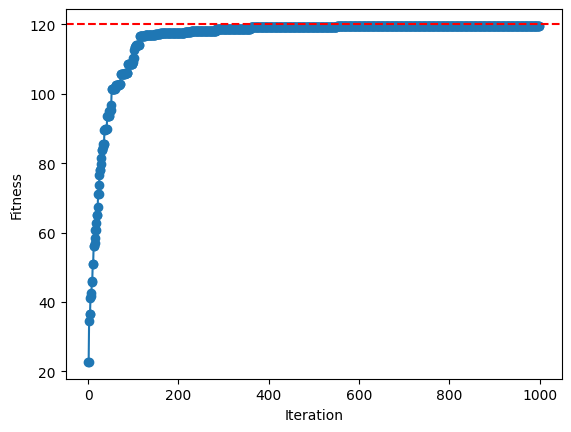

In [ ]:
F_STAR=100

plt.figure()
plt.plot(best_outputs,'-o', label='from scratch')
plt.axhline(F_STAR, color='red', linestyle='--')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Fitness')

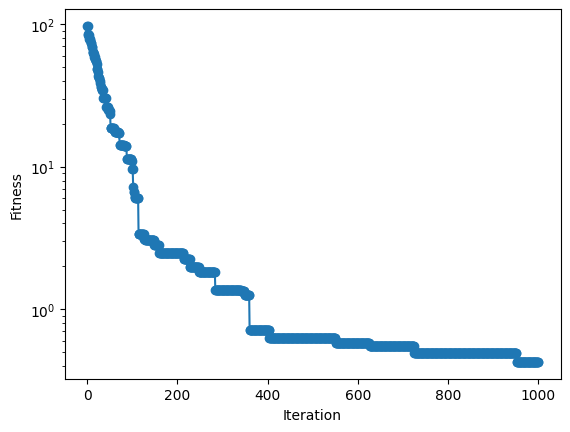

In [32]:
plt.figure()
plt.plot(F_STAR - np.array(best_outputs),'-o', label='from scratch')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.yscale('log')
plt.show()

## Yay! Looks like it works, although not very well. Explore and see what can be improved

Acknowledgement: Content from this notebook is drawn from Ahmed Gad's GA implementation, found at his [Github](https://github.com/ahmedfgad/GeneticAlgorithmPython).

## We are not done yet!

To have a black box optimizer, we need to wrap all this functionality into something that's abstracted away from the end user (in this case you). What does that mean? Think about:
- Change in the cost function (Knapsack, Rastrigin)
    - Function changes (and along with it discontinuities, ill-conditioning, non-separability...)
    - Dimensionality of the problem changes (n=1,...,100,...1000?)
    - Other concerns
- Change in the encoding (reals, bitvectors)
- ...

That is to say, write something well once and keep on reusing it---functions! Also store associated variables---classes!

## HW : Wrap this up in a GA class and reuse it in your applications (Project 1)

In [33]:
a = np.sin

In [34]:
a

<ufunc 'sin'>

In [35]:
def fitness(my_func):
    return my_func(2.0)
    
fitness(a)

np.float64(0.9092974268256817)